In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score

from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.dummy import DummyClassifier


from wordcloud import WordCloud, STOPWORDS

import string
from matplotlib import style

## Data processing and Feature Engineering

In [2]:
df = pd.read_csv('data/with_engineeredfeat_data.csv',index_col=0)

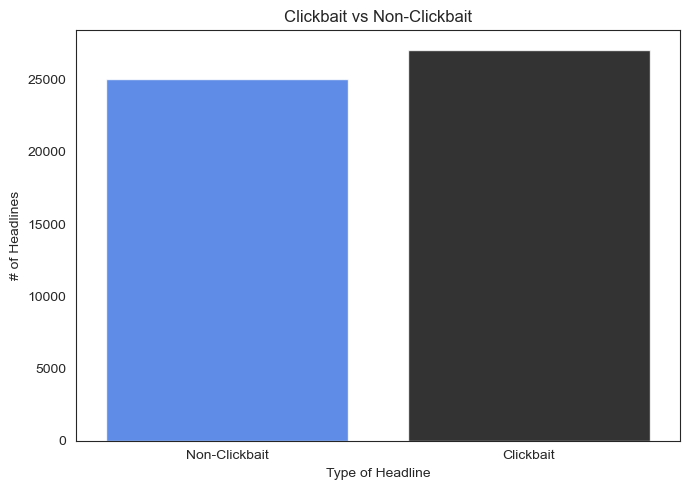

In [5]:
sns.set_style('white')
plt.figure(figsize=(7,5))
fig1=sns.countplot(x=df['class'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('Clickbait vs Non-Clickbait')
plt.ylabel('# of Headlines')
plt.xlabel('Type of Headline')
fig1.set(xticklabels=['Non-Clickbait','Clickbait'])
plt.tight_layout()
#plt.savefig('class_dist')
plt.show()


In [6]:
def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df.text = tokenize(df.text)

stopwords_list = stopwords.words('english')
df.text = df['text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [7]:
df_cb=df[df['class']==1]
df_noncb=df[df['class']==0]

cb_list=list(df_cb['text'])

total_vocab_cb = set()
for word in cb_list:
    total_vocab_cb.update(word)
len(total_vocab_cb)

noncb_list=list(df_noncb['text'])

total_vocab_noncb = set()
for word in noncb_list:
    total_vocab_noncb.update(word)
len(total_vocab_noncb)

flat_cb = [item for sublist in cb_list for item in sublist]
flat_noncb = [item for sublist in noncb_list for item in sublist]


cb_freq = FreqDist(flat_cb)
noncb_freq = FreqDist(flat_noncb)

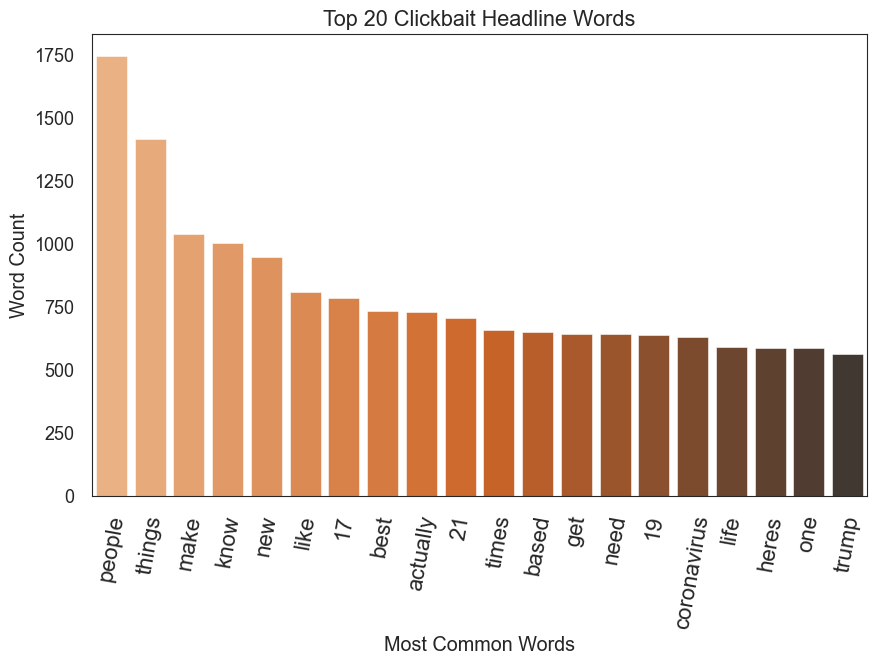

In [9]:
cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

noncb_bar_counts = [x[1] for x in noncb_freq.most_common(20)]
noncb_bar_words = [x[0] for x in noncb_freq.most_common(20)]

plt.style.use('seaborn-talk')

word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(x=cb_bar_words, y=cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style('white')
# plt.savefig('clickbait_20_bar')
plt.show()

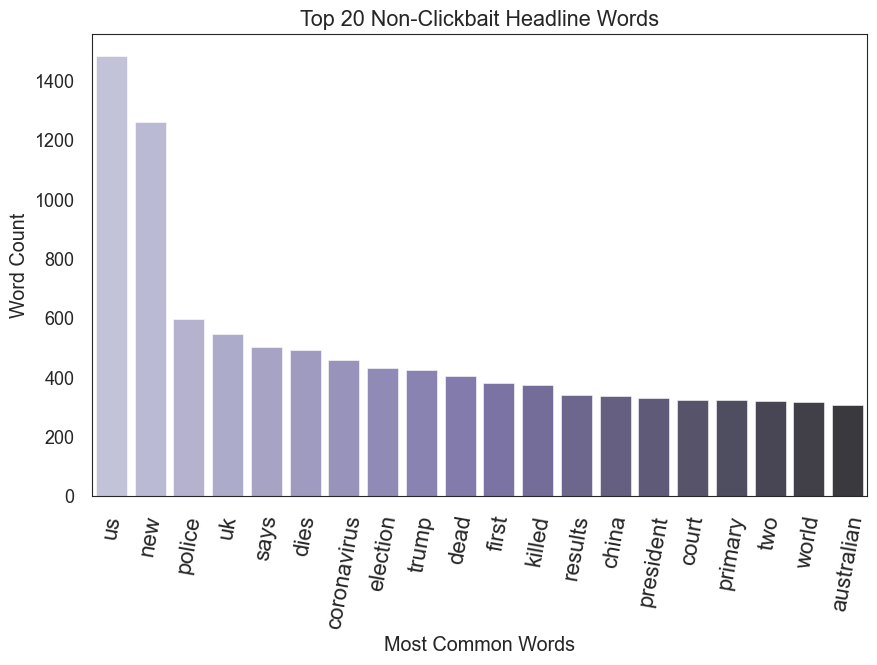

In [10]:
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(x=noncb_bar_words, y=noncb_bar_counts,palette='Purples_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Non-Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

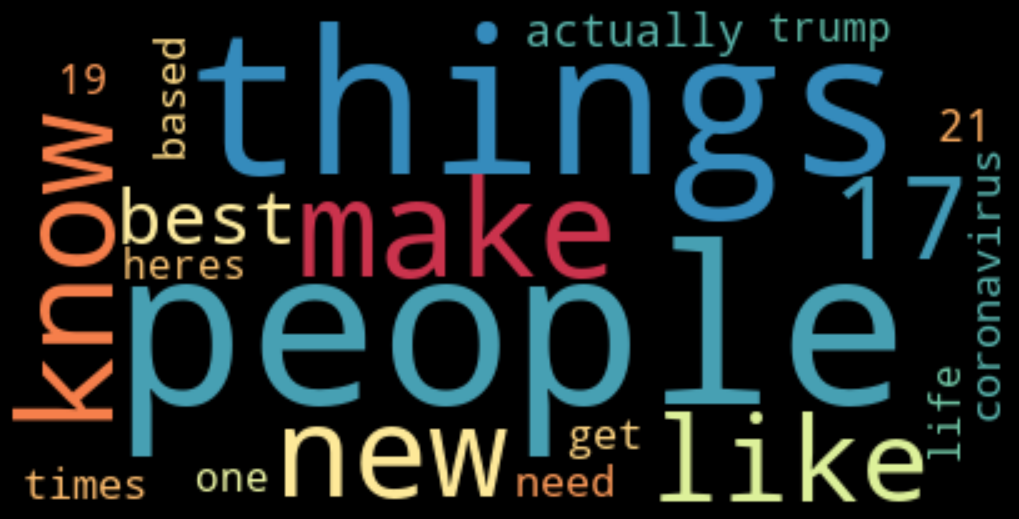

In [11]:
from wordcloud import WordCloud
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# plt.savefig('clickbait_wc')

plt.show()

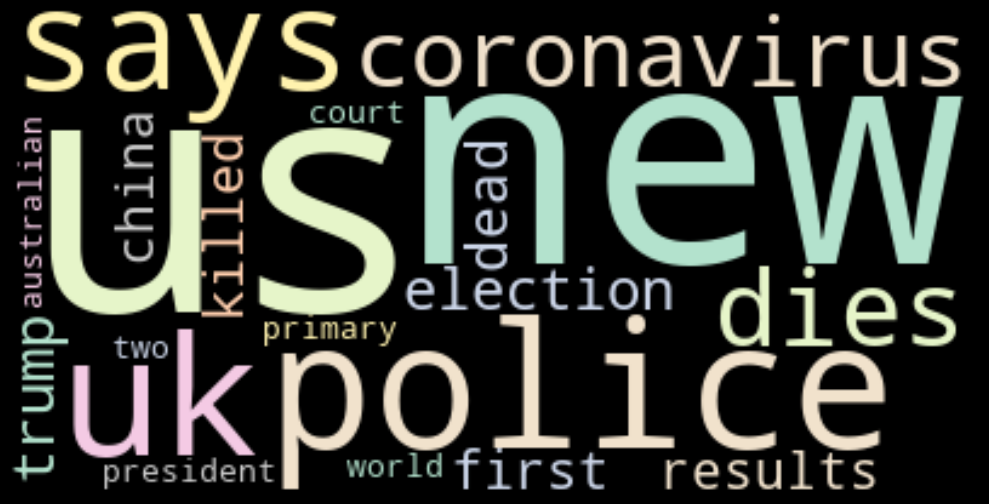

In [12]:
wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(nonclickbait_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.tight_layout()
# plt.savefig('nonclickbait_wc')

plt.show()

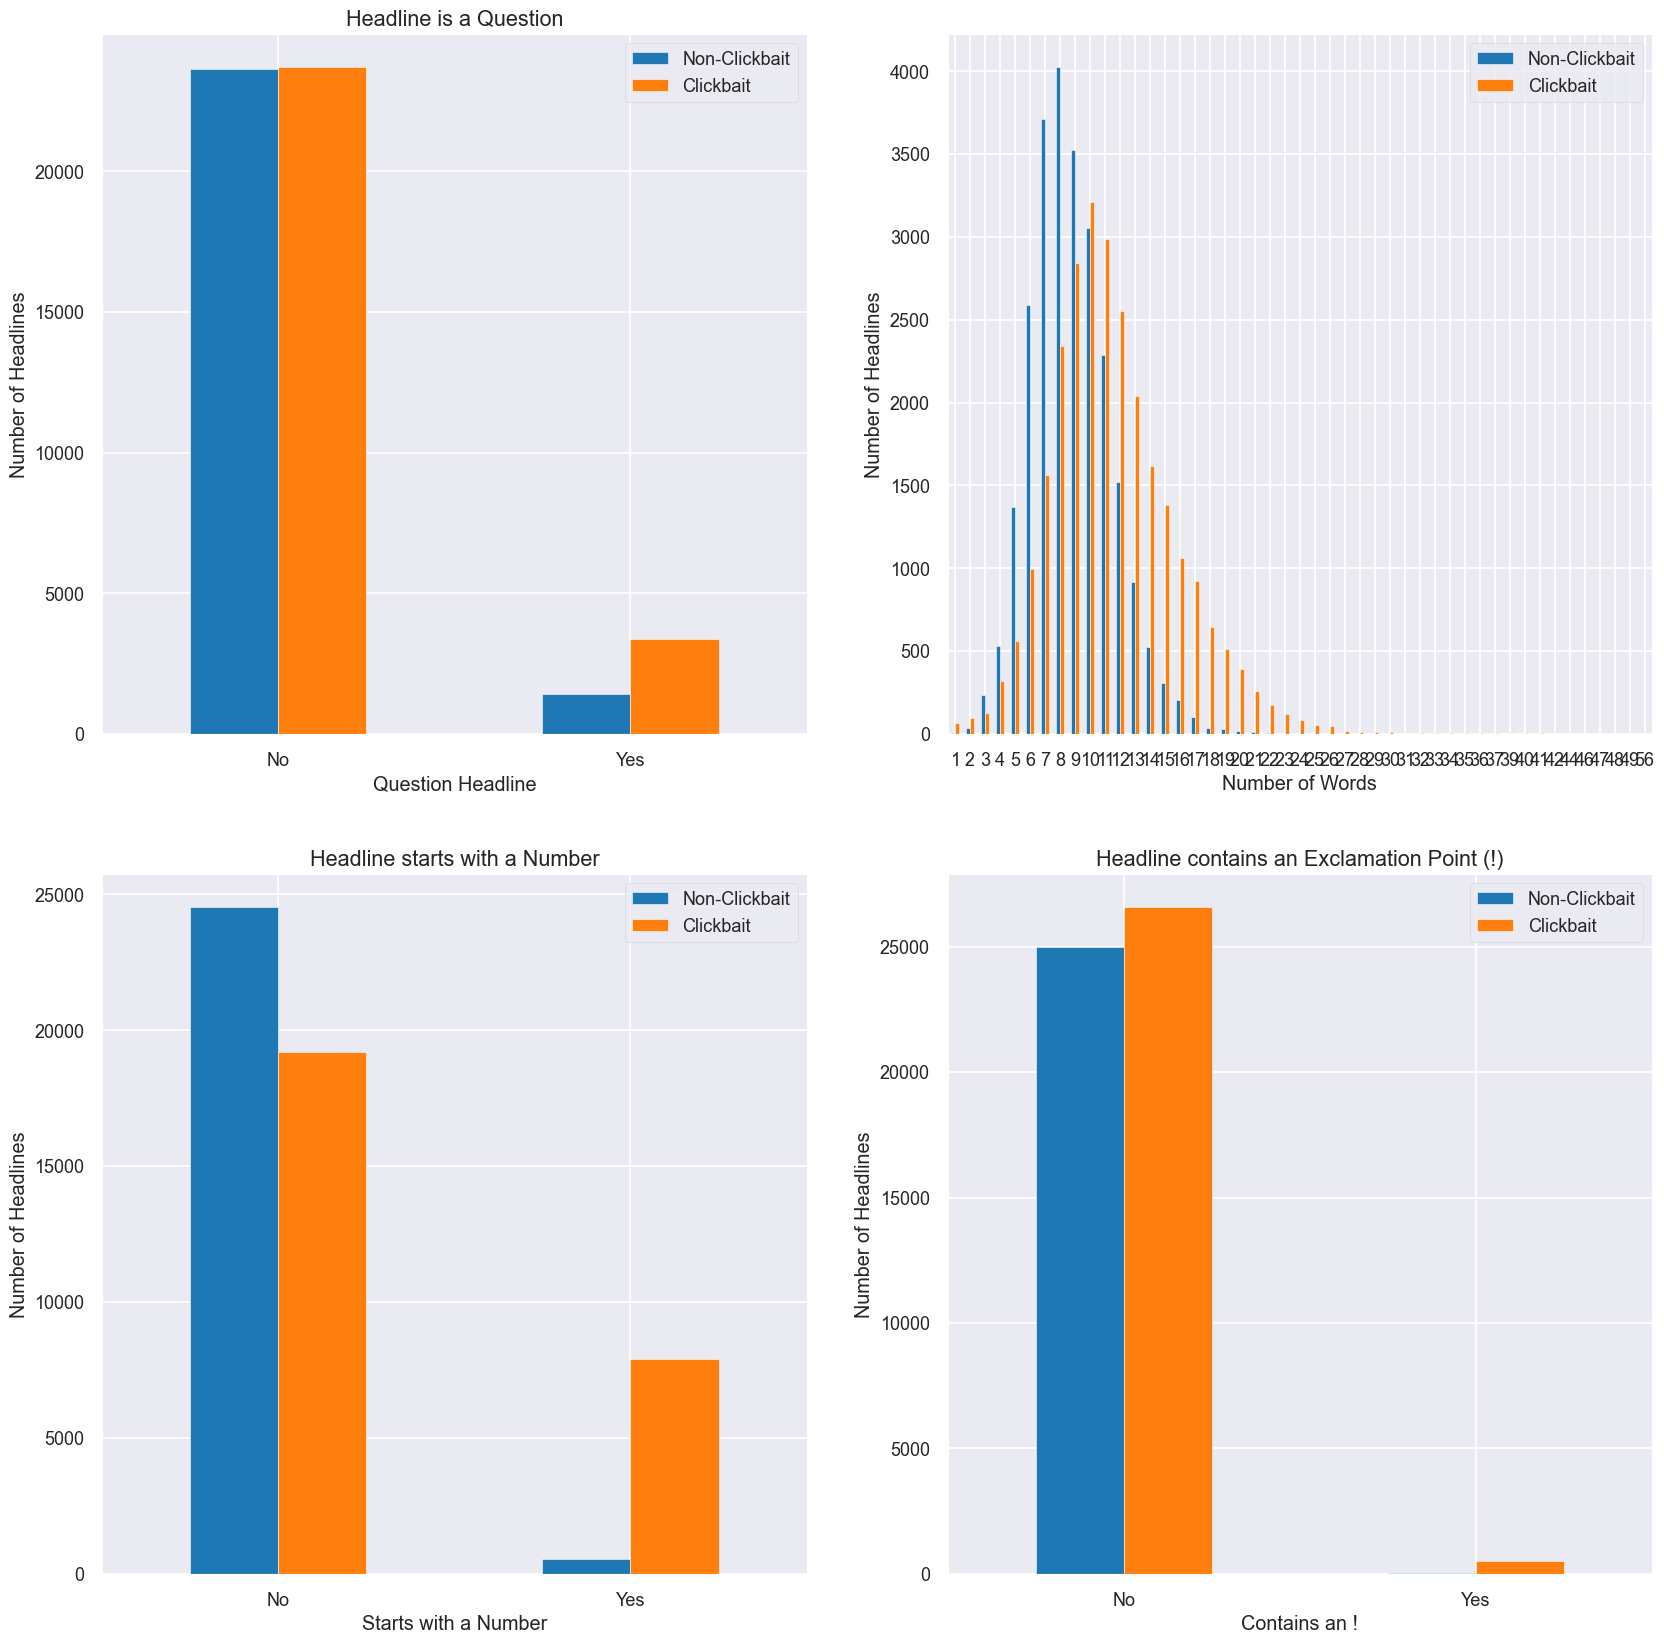

In [13]:
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

plot = df.groupby('question')['class'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline is a Question')

plot = df.groupby('headline_words')['class'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])


plot = df.groupby('starts_with_num')['class'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Starts with a Number')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline starts with a Number')

plot = df.groupby('exclamation')['class'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline contains an Exclamation Point (!)')

style.use('ggplot')
plt.show()



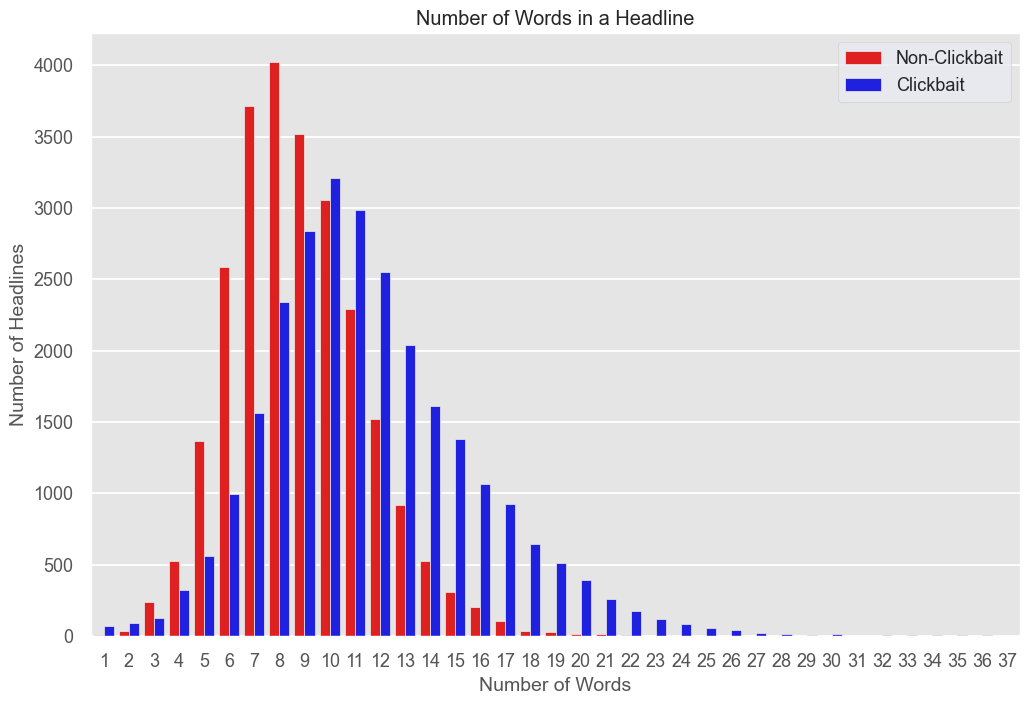

In [15]:
df_words = df[df['headline_words'] < 38]

sns.countplot(x=df_words['headline_words'],hue=df_words['class'],palette=['red','blue'],data=df_words)
sns.set_style('darkgrid')
plt.xlabel('Number of Words',size=14)
plt.ylabel('Number of Headlines', size=14)
plt.legend(title=None,labels=['Non-Clickbait','Clickbait'],loc='upper right')
plt.title('Number of Words in a Headline')
plt.tight_layout()
# plt.savefig('num_words_comparison')

plt.show()

In [18]:
engineered_feats=df.drop(columns='text')

# engineered_feats.drop(columns='Unnamed: 0',inplace=True)
engineered_feats.corr()

,class,question,exclamation,starts_with_num,headline_words
class,1.000000,0.117118,0.079931,0.366345,0.361940
question,0.117118,1.000000,0.003738,-0.129655,-0.040834
exclamation,0.079931,0.003738,1.000000,-0.038586,0.000258
starts_with_num,0.366345,-0.129655,-0.038586,1.000000,0.015247
headline_words,0.361940,-0.040834,0.000258,0.015247,1.000000


## Modeling

In [20]:
df = pd.read_csv('data/with_engineeredfeat_data.csv',index_col=0)

In [21]:
df.shape

(52127, 6)

In [22]:
stopwords_list = stopwords.words('english')

features = df.drop(columns='class')
y = df['class']

y.value_counts()

class
1    27070
0    25057
Name: count, dtype: int64

### Setting up for modeling
- applying TFIDF transformation to headline text
    - vectorizing, tokenizing (unigrams, bigrams)
    - removing stopwords
- train/test split
- creating function for results

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['text'])
tfidf_text_test = tfidf.transform(X_test['text'])

X_train_ef = X_train.drop(columns='text')
X_test_ef = X_test.drop(columns='text')

In [24]:
from scipy import sparse

X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()


In [25]:
print(X_train.shape)
print(X_test.shape)

(39095, 203136)
(13032, 203136)


In [26]:
def train_results(preds):
    return "Training Accuracy:", accuracy_score(y_train,preds)," Training Recall:", recall_score(y_train,preds)

def test_results(preds):
    return "Testing Accuracy:", accuracy_score(y_test,preds)," Testing Recall:", recall_score(y_test,preds)

### Dummy Classifier 
- baseline model
- predicts majority class

In [27]:
dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(X_train, y_train)

dc_train_preds = dc_classifier.predict(X_train)
dc_test_preds = dc_classifier.predict(X_test)

print(train_results(dc_train_preds))
print(test_results(dc_test_preds))

('Training Accuracy:', 0.5179946284691137, ' Training Recall:', 1.0)
('Testing Accuracy:', 0.5232504604051565, ' Testing Recall:', 1.0)


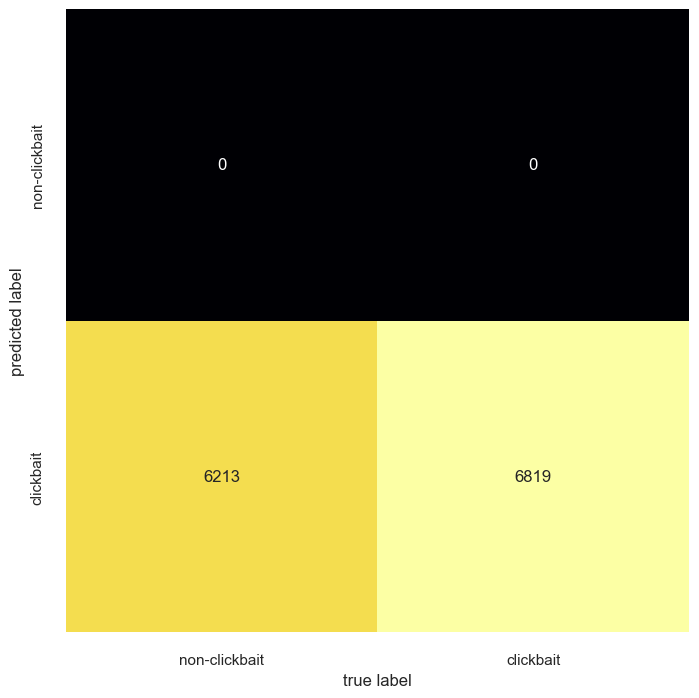

In [28]:
sns.set()

cm_dc = confusion_matrix(y_test, dc_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.tight_layout()
plt.savefig('dc_cm')

### Naive Bayes
- performs much better than dummy classifier 
- alpha adjusted to maximize accuracy & recall 

In [29]:
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

print(train_results(nb_train_preds))
print(test_results(nb_test_preds))

('Training Accuracy:', 0.9986699066376774, ' Training Recall:', 0.9992099155597255)
('Testing Accuracy:', 0.9300184162062615, ' Testing Recall:', 0.9416336706261915)


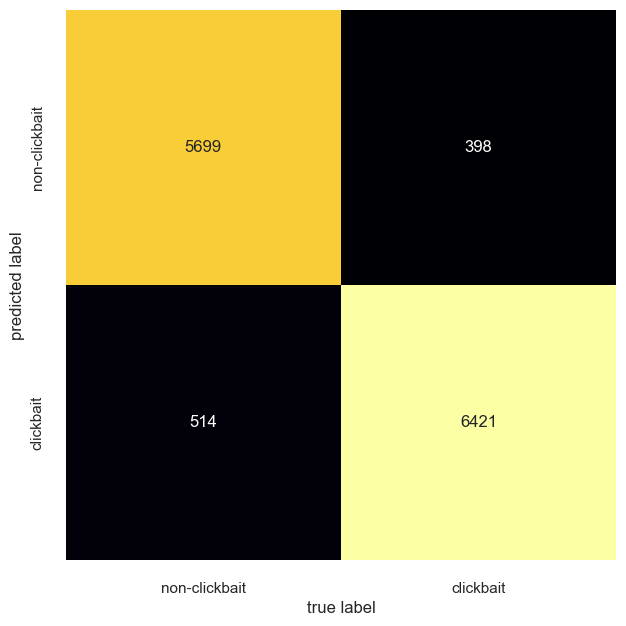

In [30]:
sns.set()

cm_dc = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('nb_cm')
plt.show()

### Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators=900, )
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_train_preds = rf_classifier.predict(X_train)

print(train_results(rf_train_preds))
print(test_results(rf_test_preds))

In [ ]:
sns.set()

cm_dc = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### SVM

In [ ]:
svm_classifier = LinearSVC(class_weight='balanced', C=10, max_iter = 1500 )

svm_classifier.fit(X_train, y_train)

svm_test_preds = svm_classifier.predict(X_test)
svm_train_preds = svm_classifier.predict(X_train)

print(train_results(svm_train_preds))
print(test_results(svm_test_preds))

sns.set()

cm_dc = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=500, class_weight = 'balanced', solver = 'liblinear', tol=0.0001)

lr.fit(X_train,y_train)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

print(train_results(lr_train_preds))
print(test_results(lr_test_preds))

sns.set()

cm_dc = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('lr_cm')

### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_test_preds = xgb_clf.predict(X_test)
xgb_train_preds = xgb_clf.predict(X_train)

print(test_results(xgb_test_preds))
print(train_results(xgb_train_preds))

sns.set()

cm_dc = confusion_matrix(y_test, xgb_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Model Interpretations
- visualize NB coefficients
- visualize SVM coefficients
- visualize Logistic Regression coefficients

In [ ]:
coef_nb = pd.DataFrame(nb_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_nb=coef_nb.T
engf_name_list=list(X_train_ef.columns)

all_feat_names_2 = []

for i in engf_name_list:
    all_feat_names_2.append(i)

for i in tfidf.get_feature_names():
    all_feat_names_2.append(i)
    
coef_df_nb['tokens']=all_feat_names_2

coef_df_nb.set_index('tokens',inplace=True)



In [ ]:
plt.style.use('seaborn-talk')

coef_df_nb[0].sort_values(ascending=False).head(15).plot(kind='bar',color='#002db3')
plt.title("Top 15 Clickbait Indicators - NB")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=35)
plt.tight_layout()
# plt.savefig('CB_coefs_nb')
sns.set_style('darkgrid')
plt.show()

In [ ]:
coef_svm = pd.DataFrame(svm_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_svm=coef_svm.T

coef_df_svm['tokens']=all_feat_names_2
coef_df_svm.set_index('tokens',inplace=True)

coef_df_svm[0].sort_values(ascending=False).head(20).plot(kind='bar',color='#5900b3')
plt.title("Top 20 Coefficients for Clickbait/Non-Clickbait Classification - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

In [ ]:
coef_lr = pd.DataFrame(lr.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_lr=coef_lr.T
coef_df_lr['tokens']=all_feat_names_2

coef_df_lr.set_index('tokens',inplace=True)

coef_df_lr[0].sort_values(ascending=True).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Non-Clickbait Classification - LR")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
# plt.savefig('noncb_lr_coeff')
plt.show()

In [ ]:
coef_df_lr[0].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Clickbait Classification - LR")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()